# Project 2 - Forecasting Service Metrics

Authors: Tatiana Barrios, Anisha Anandkrishnan

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from pandas import concat
import seaborn as sns

%matplotlib inline

1.Data preparation: Use one of the methods described in Project 1 (Advanced), Task 1 to pre-process the trace. Remove possible outliers. Reduce the dimensionality of the feature space to k = 16 using tree-based feature selection. Then, split the processed trace into training and test samples (x(t),y(t)) by assigning the samples with t < T to the training set and t ≥T to the test set. T is chosen so that the training set contains 70% of the samples.

# Task I - Using linear regression for forecasting

In [167]:
X = pd.read_csv('X.csv')
Y = pd.read_csv('Y.csv')
X.index = pd.to_datetime(X['TimeStamp'])
Y.index = pd.to_datetime(Y['TimeStamp'])
X_dropped = X.drop(labels=["Unnamed: 0", "TimeStamp"], axis=1, inplace=False)
Y_dropped = Y.drop(labels=["Unnamed: 0", "TimeStamp"], axis=1, inplace=False)
X_preprocessed = pd.DataFrame()
X_tmp = preprocessing.StandardScaler().fit_transform(X_dropped)
for i, n in enumerate(X_dropped):
        X_preprocessed[n] = X_tmp[:, i]

        
X_preprocessed.head()

/home/tatiana/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/tatiana/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,0_all_..usr,0_all_..sys,0_all_..iowait,0_all_..soft,0_all_..idle,0_cpu0_.usr,0_cpu0_.sys,0_cpu0_.iowait,0_cpu0_.soft,0_cpu0_.idle,...,36_RxBytes.1,36_TxBytes.1,40_RxPacktes.1,40_TxPacktes.1,40_RxBytes.1,40_TxBytes.1,41_RxPacktes.1,41_TxPacktes.1,41_RxBytes.1,41_TxBytes.1
0,0.069116,1.088334,0.766004,0.573967,-0.579449,1.364018,0.977205,-0.00831,-0.355042,-2.078731,...,1.583733,1.335871,1.090350,1.069987,1.211176,0.975349,1.053685,1.064968,0.971475,1.180097
1,0.247507,2.503497,0.377145,0.573967,-0.865816,1.364018,4.193380,-0.00831,-0.355042,-2.078731,...,1.551250,1.485179,1.190029,1.263907,1.110672,1.287438,1.269613,1.224345,1.294599,1.157325
2,0.158311,1.421314,0.571574,-0.290273,-0.579449,1.384053,0.993448,-0.00831,-0.355042,-1.518028,...,1.636638,1.320954,1.119925,1.012137,1.234329,0.859493,1.037388,1.111521,0.901761,1.236388
3,0.425898,1.421314,0.766004,3.382748,-1.135338,1.404089,-0.630882,-0.00831,2.626215,-0.945519,...,1.503362,1.510045,1.144023,1.126207,1.215636,1.070883,1.113167,1.141096,1.054886,1.212100
4,0.158311,0.006151,5.432315,1.654267,-2.129200,2.355777,2.585292,-0.00831,-0.355042,-2.078731,...,1.556992,1.341298,1.134713,1.095245,1.194114,1.050206,1.113574,1.146025,1.094834,1.186764


In [4]:
#converting Y_dropped to make it of the same form as X_preprocessed
Y_new = pd.DataFrame()
Y_tmp=Y_dropped.to_numpy()
for i, n in enumerate(Y_dropped):
        Y_new[n] = Y_tmp[:, i]  
# outlier rejection   
remove = []
for i in X_preprocessed:
    for j in range(len(X_preprocessed[i])):
        if j not in remove and abs(X_preprocessed[i][j]) > 20:
            remove.append(j)
X_clean = X_preprocessed.drop(labels=remove, axis=0, inplace=False)
Y_clean = Y_new.drop(labels=remove, axis=0, inplace=False)

print("Number of dropped samples: ", (len(remove)))

Number of dropped samples:  1216


In [188]:
X_clean.shape

(13265, 1751)

In [5]:
#Reduce the dimensionality of the feature space 
tree = ExtraTreesRegressor(n_estimators=100, n_jobs=20)
tree = tree.fit(X_clean, Y_clean)
model = SelectFromModel(tree,prefit=True,max_features=16,threshold=-np.inf)
X_fs = model.transform(X_clean)
top_features = []
get_feat = model.get_support()
for i, n in enumerate(X_clean):
    if get_feat[i]:
        top_features.append(n)
feature_name = []


In [6]:
for i in range(16):
    feature_name.append('feature'+str(i+1)+" : "+top_features[i])

print(feature_name)

['feature1 : 1_i127_intr.s', 'feature2 : 4_RxPacktes', 'feature3 : 4_TxBytes', 'feature4 : 15_RxPacktes', 'feature5 : 15_TxPacktes', 'feature6 : 15_TxBytes', 'feature7 : 40_RxPacktes', 'feature8 : 40_TxPacktes', 'feature9 : 4_TxBytes.1', 'feature10 : 15_TxPacktes.1', 'feature11 : 15_TxBytes.1', 'feature12 : 17_TxPacktes.1', 'feature13 : 30_TxPacktes.1', 'feature14 : 30_RxBytes.1', 'feature15 : 41_RxPacktes.1', 'feature16 : 41_TxPacktes.1']


In [181]:
X_latest = pd.DataFrame(data = X_fs,columns= feature_name)
Y_latest = pd.DataFrame(data = Y_clean,columns= Y_dropped.columns)

X_latest.head()

,feature1 : 1_i127_intr.s,feature2 : 4_RxPacktes,feature3 : 4_TxBytes,feature4 : 15_RxPacktes,feature5 : 15_TxPacktes,feature6 : 15_TxBytes,feature7 : 40_RxPacktes,feature8 : 40_TxPacktes,feature9 : 4_TxBytes.1,feature10 : 15_TxPacktes.1,feature11 : 15_TxBytes.1,feature12 : 17_TxPacktes.1,feature13 : 30_TxPacktes.1,feature14 : 30_RxBytes.1,feature15 : 41_RxPacktes.1,feature16 : 41_TxPacktes.1
0,0.855128,1.299455,1.194544,1.247687,1.290084,1.219757,1.190029,1.263907,1.194544,1.290084,1.219757,1.238812,1.229687,1.194057,1.269613,1.224345
1,0.879198,1.025629,1.240098,1.079864,0.999243,1.105230,1.119925,1.012137,1.240098,0.999243,1.105230,1.077493,1.056521,1.230830,1.037388,1.111521
2,0.566292,1.138740,1.187528,1.132818,1.110978,1.172840,1.144023,1.126207,1.187528,1.110978,1.172840,1.135340,1.155939,1.193328,1.113167,1.141096
3,0.746815,1.063468,1.318807,1.068458,1.108240,1.253234,1.114448,1.061839,1.318807,1.108240,1.253234,1.048163,1.100525,1.187147,1.030870,1.114260
4,1.143965,1.235169,1.119624,1.169071,1.209569,1.173450,1.208103,1.229686,1.119624,1.209569,1.173450,1.205407,1.186497,1.231431,1.232131,1.206819


In [187]:
Y_latest.shape

(13265, 1)

In [182]:
Y_latest.head()

,ReadsAvg,WritesAvg
1,59.8588,118.4950
2,57.8251,116.8042
3,63.8154,128.3462
5,57.4767,113.0049
6,58.3151,113.5318


In [183]:
Y_latest = Y_latest.drop(labels=["WritesAvg"], axis=1, inplace=False)

In [185]:
X_latest.tail()

,feature1 : 1_i127_intr.s,feature2 : 4_RxPacktes,feature3 : 4_TxBytes,feature4 : 15_RxPacktes,feature5 : 15_TxPacktes,feature6 : 15_TxBytes,feature7 : 40_RxPacktes,feature8 : 40_TxPacktes,feature9 : 4_TxBytes.1,feature10 : 15_TxPacktes.1,feature11 : 15_TxBytes.1,feature12 : 17_TxPacktes.1,feature13 : 30_TxPacktes.1,feature14 : 30_RxBytes.1,feature15 : 41_RxPacktes.1,feature16 : 41_TxPacktes.1
13260,-1.660156,-1.067333,-1.251440,-1.185340,-1.205895,-1.250246,-1.207193,-1.192681,-1.251440,-1.205895,-1.250246,-1.185446,-1.166937,-1.224883,-1.189521,-1.207387
13261,-1.840679,-1.587725,-1.418037,-1.605305,-1.567393,-1.416353,-1.568666,-1.606593,-1.418037,-1.567393,-1.416353,-1.602185,-1.597205,-1.518893,-1.606303,-1.568861
13262,-1.948993,-1.590573,-1.427275,-1.587382,-1.558082,-1.423366,-1.559355,-1.588668,-1.427275,-1.558082,-1.423366,-1.587520,-1.569499,-1.522781,-1.588784,-1.559550
13263,-2.249864,-1.585284,-1.425502,-1.595528,-1.561916,-1.412389,-1.556617,-1.596816,-1.425502,-1.561916,-1.412389,-1.595668,-1.583352,-1.515576,-1.594488,-1.551883
13264,-2.298004,-1.560464,-1.432476,-1.562941,-1.541650,-1.429090,-1.542924,-1.566669,-1.432476,-1.541650,-1.429090,-1.563078,-1.559720,-1.525133,-1.566376,-1.543120


In [96]:
#splitting the processed trace into training and test samples and time index sorting
X_train, X_test, Y_train, Y_test = train_test_split(X_latest, Y_latest, test_size=0.3, shuffle = False)
print(X_train.shape,"(70% of the samples in training set and 16 features)")
X_train = X_train.sort_index(axis = 0)
X_test = X_test.sort_index(axis = 0)
Y_train = Y_train.sort_index(axis = 0)
Y_test = Y_test.sort_index(axis = 0)


## T is the index 9285

(9285, 16) (70% of the samples in training set and 16 features)


In [102]:
Y_train.shape

(9285, 1)

In [166]:
X_latest.head()

,feature1 : 1_i127_intr.s,feature2 : 4_RxPacktes,feature3 : 4_TxBytes,feature4 : 15_RxPacktes,feature5 : 15_TxPacktes,feature6 : 15_TxBytes,feature7 : 40_RxPacktes,feature8 : 40_TxPacktes,feature9 : 4_TxBytes.1,feature10 : 15_TxPacktes.1,feature11 : 15_TxBytes.1,feature12 : 17_TxPacktes.1,feature13 : 30_TxPacktes.1,feature14 : 30_RxBytes.1,feature15 : 41_RxPacktes.1,feature16 : 41_TxPacktes.1
0,0.855128,1.299455,1.194544,1.247687,1.290084,1.219757,1.190029,1.263907,1.194544,1.290084,1.219757,1.238812,1.229687,1.194057,1.269613,1.224345
1,0.879198,1.025629,1.240098,1.079864,0.999243,1.105230,1.119925,1.012137,1.240098,0.999243,1.105230,1.077493,1.056521,1.230830,1.037388,1.111521
2,0.566292,1.138740,1.187528,1.132818,1.110978,1.172840,1.144023,1.126207,1.187528,1.110978,1.172840,1.135340,1.155939,1.193328,1.113167,1.141096
3,0.746815,1.063468,1.318807,1.068458,1.108240,1.253234,1.114448,1.061839,1.318807,1.108240,1.253234,1.048163,1.100525,1.187147,1.030870,1.114260
4,1.143965,1.235169,1.119624,1.169071,1.209569,1.173450,1.208103,1.229686,1.119624,1.209569,1.173450,1.205407,1.186497,1.231431,1.232131,1.206819


In [165]:
Y_latest.head()

,ReadsAvg
1,59.8588
2,57.8251
3,63.8154
5,57.4767
6,58.3151


2. Create a new training set and a new test set with samples of structure ([x(t−l); ... x(t)]; [y(t);... y(t+h)]). For the KV service, h is incremented and l is decremented by 1 sec intervals between samples. 

3. Using linear regression, train models for l = 0; ::; 10 in the feature space and h = 0; ::; 10 in the target space. The model with l = 0 corresponds to prediction using the current sample. A model with l > 0 corresponds to learning on l samples into the past and predicting 0; :::; 10 steps into the future. Evaluate the models by computing the error (NMAE) on the test set. Display the results in a table with rows representing the time horizon h = 0; ::; 10 and columns representing the lag l = 0; ::; 10. You need to train one model for each lag value (11 models in total).

In [18]:
#NMAE
def nmae(y, y_hat):
    y_av = np.mean(y)
    y_sum = np.sum(np.abs(y - y_hat))
    return y_sum/(len(y)*y_av)

In [120]:
def future_columns(df, h):
    nv = df.shape[1]
    original_names = df.columns
    col, names = list(), list()
    for i in range(0, h+1):
        col.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (original_names[j])) for j in range(nv)]
        else:
            names += [('%s(t+%d)' % (original_names[j], i)) for j in range(nv)]
    concated_ = concat(col, axis=1)
    concated_.columns = names
    
    #This might bring errors, but i dont know if its better to drop them or to fill them at this point
    concated_.fillna(0, inplace=True)
    return concated_
    

In [144]:
def past_values(df, l):
    nv = df.shape[1]
    original_names = df.columns
    col, names = list(), list()
    for i in range(l, -1, -1):
        col.append(df.shift(i))
        if i == 0:
            names += [('%s(t)' % (original_names[j])) for j in range(nv)]
        else:
            names += [('%s(t+%d)' % (original_names[j], i)) for j in range(nv)]
    concated_ = concat(col, axis=1)
    concated_.columns = names
    
    #This might bring errors, but i dont know if its better to drop them or to fill them at this point
    concated_.fillna(0, inplace=True)
    return concated_

In [138]:
def nmaes_array(df_test, df_pre, h):
    nmaes = []
    for i in range(0, h+1):
        y_predict_i = df_pre[:, i]
        y_test_o = df_test.iloc[:, i].to_numpy()
        nmaes.append(nmae(y_test_o, y_predict_i))
    return nmaes

In [121]:
# we only need to train a model for each lag value and 
# meanwhile set the horizon value to 10, then the total number of models is 11.
# This means horizon value is always 10 for all lag values, otherwise we would have to train 121 models
Y_new_test = future_columns(Y_test, 10)
Y_new_train = future_columns(Y_train, 10)

In [122]:
Y_new_train.shape

(9285, 11)

In [123]:
# l = 0 A model with l > 0 corresponds to learning on l samples into the past and predicting 0; :::; 10 steps into the future
reg_l0 = MultiOutputRegressor(LinearRegression()).fit(X_train, Y_new_train)

In [124]:
Y_predict_l0 = reg_l0.predict(X_test) 

In [139]:
h = 10
nmaes_l0 = nmaes_array(Y_new_test, Y_predict_l0, h)

In [158]:
# l = 1
X_train_l1 = past_values(X_train, 1)
X_test_l1 = past_values(X_test, 1)
reg_l1 = MultiOutputRegressor(LinearRegression()).fit(X_train_l1, Y_new_train)
Y_predict_l1 = reg_l1.predict(X_test_l1) 
nmaes_l1 = nmaes_array(Y_new_test, Y_predict_l1, h)

In [161]:
d = {'nmaes_l0': nmaes_l0, 'nmaes_l1': nmaes_l1}
nmaesdf = pd.DataFrame(data=d)
nmaesdf.head()

,nmaes_l0,nmaes_l1
0,0.030451,0.028629
1,0.026661,0.026011
2,0.025779,0.025752
3,0.026950,0.027052
4,0.028725,0.029317


In [190]:
for i in range(2,11):
    X_train_l = past_values(X_train, i)
    X_test_l = past_values(X_test, i)
    reg_l = MultiOutputRegressor(LinearRegression()).fit(X_train_l, Y_new_train)
    Y_predict_l = reg_l.predict(X_test_l) 
    nmaes_l = nmaes_array(Y_new_test, Y_predict_l, h)
    nmaesdf['nmaes_l'+str(i)] = nmaes_l

In [193]:
%store nmaesdf

Stored 'nmaesdf' (DataFrame)


In [194]:
nmaesdf

,nmaes_l0,nmaes_l1,nmaes_l2,nmaes_l3,nmaes_l4,nmaes_l5,nmaes_l6,nmaes_l7,nmaes_l8,nmaes_l9,nmaes_l10
0,0.030451,0.028629,0.027781,0.027420,0.027105,0.026969,0.026794,0.026655,0.026723,0.026768,0.026732
1,0.026661,0.026011,0.025897,0.025848,0.025971,0.025945,0.025910,0.026075,0.026188,0.026230,0.026256
2,0.025779,0.025752,0.025737,0.026039,0.026238,0.026162,0.026250,0.026315,0.026417,0.026504,0.026522
3,0.026950,0.027052,0.027523,0.027938,0.027945,0.027942,0.027919,0.028022,0.028128,0.028155,0.028209
4,0.028725,0.029317,0.029789,0.029781,0.029823,0.029701,0.029673,0.029737,0.029742,0.029811,0.030001
5,0.030983,0.031682,0.031591,0.031609,0.031474,0.031298,0.031219,0.031104,0.031151,0.031344,0.031528
6,0.032591,0.032725,0.032733,0.032522,0.032382,0.032196,0.031936,0.031862,0.032016,0.032186,0.032096
7,0.033312,0.033526,0.033302,0.033098,0.032934,0.032552,0.032353,0.032438,0.032565,0.032433,0.032295
8,0.033836,0.033819,0.033584,0.033378,0.033055,0.032739,0.032742,0.032782,0.032640,0.032503,0.032488
9,0.034143,0.034082,0.033852,0.033467,0.033132,0.033072,0.033013,0.032793,0.032642,0.032607,0.032571


In [199]:
nmaesdf.index

RangeIndex(start=0, stop=11, step=1)

[Text(0, 0.5, 'NMAE'), Text(0.5, 0, 'lag')]

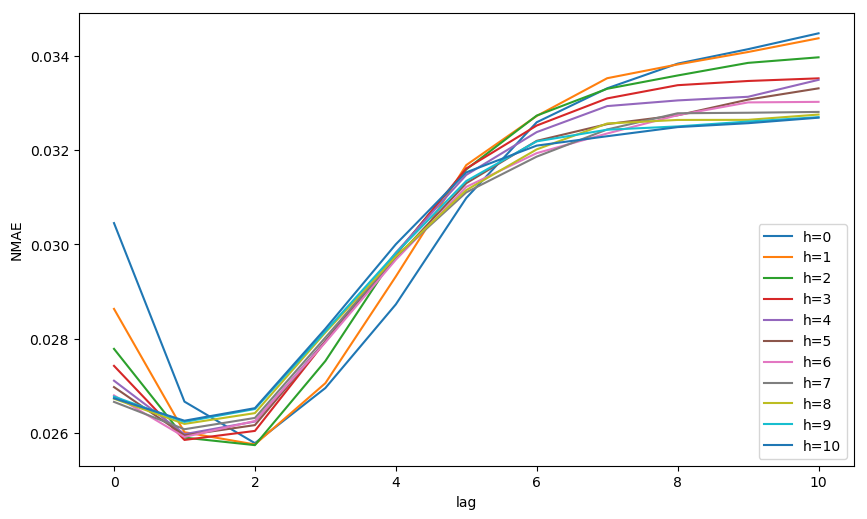

In [213]:
fig, linep_ = plt.subplots(figsize = (10,6), dpi = 100)

linep_ = sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l0", label="h=0")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l1", label="h=1")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l2", label="h=2")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l3", label="h=3")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l4", label="h=4")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l5", label="h=5")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l6", label="h=6")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l7", label="h=7")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l8", label="h=8")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l9", label="h=9")
sns.lineplot(data=nmaesdf, x=nmaesdf.index, y="nmaes_l10", label="h=10")


linep_.set(xlabel='lag', ylabel='NMAE')

In [215]:
fig.savefig('lags.png', dpi=300, bbox_inches='tight')